In [2]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from scipy import stats

## 사기 혐의자 데이터 읽기

In [98]:
# 상담센터에 거래 관련 신고된 uid
read_path = '../csv/help_uid.csv'
fraud_uid_help = pd.read_csv(read_path)

fraud_uid_help = fraud_uid_help.rename(columns={'value': 'uid'})

fraud_uid_help['uid'] = fraud_uid_help['uid'].astype(str)

fraud_uid_help['help'] = 1

fraud_uid_help.tail()

,uid,help
103113,1475933,1
103114,9313382,1
103115,9302282,1
103116,6223410,1
103117,9241528,1


In [99]:
# 영구 제재 받은 uid
read_path = '../csv/block_uid.csv'
fraud_uid_block = pd.read_csv(read_path)

fraud_uid_block['block'] = 1

fraud_uid_block['uid'] = fraud_uid_block['uid'].astype(str)

fraud_uid_block.tail()

,uid,block
143847,5834292,1
143848,5067006,1
143849,8755369,1
143850,5083812,1
143851,7961342,1


In [109]:
# 운영팀에서 관리하는 거래신고 접수 uid
read_path = '../csv/fraud_report_data_2019_2016.csv'
fraud_operation = pd.read_csv(read_path)

fraud_operation.columns = ['reported_date', 'product_name', 'price', 'reporter_uid', 'fraud_uid']

fraud_operation['block_by_operation'] = 1

fraud_operation.tail()

,reported_date,product_name,price,reporter_uid,fraud_uid,block_by_operation
15951,NaN,갤럭시A7,"125,000",1370542.0,2667809,1
15952,NaN,갤럭시노트fe,"350,000",3224068.0,4087003,1
15953,NaN,아이폰5s,"123,000",4016158.0,4770542,1
15954,NaN,핸드백,"25,000",938074.0,5335535,1
15955,NaN,gtx1060 6g,"250,000",1890173.0,5699420,1


### 사기 혐의자 데이터 합치기

In [116]:
fraud_uid_operation = fraud_operation[['fraud_uid', 'block_by_operation']]

fraud_uid_operation = fraud_uid_operation.rename(columns={'fraud_uid': 'uid'})

fraud_uid_operation['uid'] = fraud_uid_operation['uid'].astype(str)

fraud_uid_operation.tail()

,uid,block_by_operation
15951,2667809,1
15952,4087003,1
15953,4770542,1
15954,5335535,1
15955,5699420,1


In [118]:
fraud_uid_1 = pd.merge(fraud_uid_help, fraud_uid_block, on='uid', how='outer')

fraud_uid = pd.merge(fraud_uid_1, fraud_uid_operation, on='uid', how='outer')

fraud_uid = fraud_uid.fillna(0)

fraud_uid.tail()

,uid,help,block,block_by_operation
212508,6534153,0.0,0.0,1.0
212509,2610325,0.0,0.0,1.0
212510,3927135,0.0,0.0,1.0
212511,1806746,0.0,0.0,1.0
212512,8970553,0.0,0.0,1.0


In [119]:
def merge_block(row):
    if row['help'] == 1 and row['block'] == 1 and row['block_by_operation'] == 1:
        return 'help&block&operation'
    elif row['help'] == 1 and row['block'] == 1:
        return 'help&block'
    elif row['block'] == 1 and row['block_by_operation'] == 1:
        return 'block&operation'
    elif row['help'] == 1 and row['block_by_operation'] == 1:
        return 'help&operation'
    elif row['help'] == 1:
        return 'help'
    elif row['block'] == 1:
        return 'block'
    elif row['block_by_operation'] == 1:
        return 'operation'
    else:
        return 'missing'
    
fraud_uid['black_source'] = fraud_uid.apply(merge_block, axis=1)

fraud_uid.tail()

,uid,help,block,block_by_operation,black_source
212508,6534153,0.0,0.0,1.0,operation
212509,2610325,0.0,0.0,1.0,operation
212510,3927135,0.0,0.0,1.0,operation
212511,1806746,0.0,0.0,1.0,operation
212512,8970553,0.0,0.0,1.0,operation


In [120]:
fraud_uid.groupby(['black_source'], as_index=False).agg({'uid':'count'})

,black_source,uid
0,block,103892
1,block&operation,826
2,help,63073
3,help&block,29592
4,help&block&operation,12952
5,help&operation,1005
6,operation,1173


## 거래 데이터 읽기

In [129]:
read_path = '../csv/pay_history.csv'
pay_raw = pd.read_csv(read_path)

pay_raw = pay_raw.rename(columns={'buyer_id': 'buyer_uid', 'seller_id': 'seller_uid', 'deposit_done_date': 'updated_at'})

pay_raw.tail()

,updated_at,buyer_uid,seller_uid,total_price
90146,2019-01-25 20:32:45,4161761,4414597,148170
90147,2019-02-01 20:31:30,603779,5071323,31450
90148,2019-01-25 20:32:45,8069149,7742258,47350
90149,2019-01-25 20:32:45,31040,2459314,143100
90150,2019-01-25 20:32:45,7526483,7566393,2576000


In [131]:
read_path = '../csv/bunp_history.csv'
bunp_raw = pd.read_csv(read_path)

bunp_raw = bunp_raw.rename(columns={'seller_pid_price': 'total_price'})

bunp_raw.tail()

,updated_at,buyer_uid,seller_uid,total_price
10933703,2019-07-02 13:38:54,5814572,6226054,53000
10933704,2019-07-02 13:39:36,6914581,8934182,59800
10933705,2019-07-02 13:42:58,773650,1512351,18500
10933706,2019-07-02 13:43:04,5701462,7505410,50000
10933707,2019-07-02 13:48:37,5227540,9249456,55000


In [141]:
transaction = pd.concat([bunp_raw, pay_raw], axis=0).reset_index()

transaction['seller_uid'] = transaction['seller_uid'].astype(str)

transaction.tail()

,index,updated_at,buyer_uid,seller_uid,total_price
11023854,90146,2019-01-25 20:32:45,4161761,4414597,148170
11023855,90147,2019-02-01 20:31:30,603779,5071323,31450
11023856,90148,2019-01-25 20:32:45,8069149,7742258,47350
11023857,90149,2019-01-25 20:32:45,31040,2459314,143100
11023858,90150,2019-01-25 20:32:45,7526483,7566393,2576000


In [142]:
transaction_black = pd.merge(transaction, fraud_uid[['uid', 'black_source']], 
                             left_on=['seller_uid'], right_on=['uid'], how='left')

transaction_black.tail()

,index,updated_at,buyer_uid,seller_uid,total_price,uid,black_source
11179561,90146,2019-01-25 20:32:45,4161761,4414597,148170,4414597,help
11179562,90147,2019-02-01 20:31:30,603779,5071323,31450,NaN,NaN
11179563,90148,2019-01-25 20:32:45,8069149,7742258,47350,NaN,NaN
11179564,90149,2019-01-25 20:32:45,31040,2459314,143100,NaN,NaN
11179565,90150,2019-01-25 20:32:45,7526483,7566393,2576000,NaN,NaN


# 기초 데이터 읽기

### 이름 변경 내역 파일 읽기

In [3]:
read_path = '../csv/changed_name.csv'
fraud_name = pd.read_csv(read_path)

fraud_name['is_black'] = fraud_name['is_black'].replace('normal', 0)
fraud_name['is_black'] = fraud_name['is_black'].replace('black', 1)

fraud_name.tail()

,is_black,uid,changed_name
4095222,0,9315495,1
4095223,0,9315496,1
4095224,0,9315512,1
4095225,0,9315513,1
4095226,0,9315544,1


### T-Test

In [6]:
fraud_name_normal = fraud_name[fraud_name['is_black'] == 0]
fraud_name_black = fraud_name[fraud_name['is_black'] == 1]

In [28]:
# 샘플 수 비교
np.size(fraud_name_normal['changed_name']), np.size(fraud_name_black['changed_name'])

(3983427, 111800)

In [8]:
# 평균 비교
np.mean(fraud_name_normal['changed_name']), np.mean(fraud_name_black['changed_name'])

(1.4122430259171312, 1.7182200357781754)

In [7]:
tTestResultName = stats.ttest_ind(fraud_name_normal['changed_name'], fraud_name_black['changed_name'], equal_var=False)

tTestResultName

Ttest_indResult(statistic=-62.24629954059341, pvalue=0.0)

### 폰 변경 내역 파일 읽기

In [10]:
read_path = '../csv/changed_phone.csv'
fraud_phone = pd.read_csv(read_path)

fraud_phone['is_black'] = fraud_phone['is_black'].replace('normal', 0)
fraud_phone['is_black'] = fraud_phone['is_black'].replace('black', 1)

fraud_phone.tail()

,is_black,uid,changed_phone
351128,0,9315205,1
351129,0,9315206,1
351130,0,9315557,1
351131,0,9315569,1
351132,0,9315593,1


### T-Test

In [11]:
fraud_phone_normal = fraud_phone[fraud_phone['is_black'] == 0]
fraud_phone_black = fraud_phone[fraud_phone['is_black'] == 1]

In [27]:
# 샘플 수 비교
np.size(fraud_phone_normal['changed_phone']), np.size(fraud_phone_black['changed_phone'])

(333597, 17536)

In [13]:
# 평균 비교
np.mean(fraud_phone_normal['changed_phone']), np.mean(fraud_phone_black['changed_phone'])

(1.2256165373189807, 1.402657390510949)

In [15]:
tTestResultPhone = stats.ttest_ind(fraud_phone_normal['changed_phone'], fraud_phone_black['changed_phone'], equal_var=False)

tTestResultPhone

Ttest_indResult(statistic=-23.959847561165333, pvalue=5.718419162056929e-125)

### 리뷰 받은 사람 파일 읽기

In [19]:
read_path = '../csv/review_ee.csv'
fraud_review_ee = pd.read_csv(read_path)

fraud_review_ee['is_black'] = fraud_review_ee['is_black'].replace('normal', 0)
fraud_review_ee['is_black'] = fraud_review_ee['is_black'].replace('black', 1)

fraud_review_ee = fraud_review_ee.rename(columns={'shop_uid': 'uid'})

fraud_review_ee.tail()

,is_black,uid,review
960295,0,9303612,1
960296,0,9305161,1
960297,0,9310247,1
960298,0,9310368,1
960299,0,9313138,1


### T-Test

In [20]:
fraud_review_ee_normal = fraud_review_ee[fraud_review_ee['is_black'] == 0]
fraud_review_ee_black = fraud_review_ee[fraud_review_ee['is_black'] == 1]

In [26]:
# 샘플 수 비교
np.size(fraud_review_ee_normal['review']), np.size(fraud_review_ee_black['review'])

(897324, 62976)

In [23]:
# 평균 비교
np.mean(fraud_review_ee_normal['review']), np.mean(fraud_review_ee_black['review'])

(5.97372520962328, 8.573234247967479)

In [24]:
tTestResultReviewEe = stats.ttest_ind(fraud_review_ee_normal['review'], fraud_review_ee_black['review'], equal_var=False)

tTestResultReviewEe

Ttest_indResult(statistic=-23.21982978574343, pvalue=7.980710979230879e-119)

### 리뷰 남긴 사람 파일 읽기

In [30]:
read_path = '../csv/review_er.csv'
fraud_review_er = pd.read_csv(read_path)

fraud_review_er['is_black'] = fraud_review_er['is_black'].replace('normal', 0)
fraud_review_er['is_black'] = fraud_review_er['is_black'].replace('black', 1)

fraud_review_er = fraud_review_er.rename(columns={'writer_uid': 'uid'})

fraud_review_er.tail()

,is_black,uid,review
1109973,0,9309329,1
1109974,0,9309339,1
1109975,0,9309423,1
1109976,0,9311843,1
1109977,0,9313932,1


### T-Test

In [31]:
fraud_review_er_normal = fraud_review_er[fraud_review_er['is_black'] == 0]
fraud_review_er_black = fraud_review_er[fraud_review_er['is_black'] == 1]

In [32]:
# 샘플 수 비교
np.size(fraud_review_er_normal['review']), np.size(fraud_review_er_black['review'])

(1058974, 51004)

In [33]:
# 평균 비교
np.mean(fraud_review_er_normal['review']), np.mean(fraud_review_er_black['review'])

(5.215598305529692, 7.393478942828014)

In [34]:
tTestResultReviewEr = stats.ttest_ind(fraud_review_er_normal['review'], fraud_review_er_black['review'], equal_var=False)

tTestResultReviewEr

Ttest_indResult(statistic=-25.846254524648977, pvalue=2.049059005337516e-146)

# 데이터 merge

In [172]:
fraud_1 = pd.merge(fraud_name, fraud_phone, on =['is_black', 'uid'], how='outer')

fraud_2 = pd.merge(fraud_1, fraud_review_ee, on =['is_black', 'uid'], how='outer')

fraud = pd.merge(fraud_2, fraud_review_er, on =['is_black', 'uid'], how='outer')

fraud = fraud.rename(columns={'review_x': 'review_ee', 'review_y': 'review_er'})

fraud.fillna(0)

,is_black,uid,changed_name,changed_phone,review_ee,review_er
0,1,0,7.0,0.0,2044.0,18.0
1,1,6,1.0,0.0,0.0,0.0
2,1,1717,1.0,0.0,2.0,2.0
3,1,2645,1.0,0.0,24.0,44.0
4,1,2709,1.0,1.0,0.0,1.0
5,1,3028,1.0,0.0,3.0,3.0
6,1,4299,1.0,0.0,1.0,0.0
7,1,4383,3.0,0.0,13.0,9.0
8,1,5063,2.0,0.0,322.0,86.0
9,1,5933,1.0,2.0,11.0,2.0


In [151]:
y = fraud_name['is_black']
X = fraud_name['changed_name']

logit_mod = sm.Logit(y, X)
# logit_res = logit_mod.fit(disp=0)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.177909
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               is_black   No. Observations:              4095227
Model:                          Logit   Df Residuals:                  4095226
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Jul 2019   Pseudo R-squ.:                 -0.4207
Time:                        17:16:10   Log-Likelihood:            -7.2858e+05
converged:                       True   LL-Null:                   -5.1284e+05
                                        LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
changed_name    -2.7745      0.002  -1195.259      0.000      -2.779      -2.770


In [ ]:
xx = np.linspace(0, 100, 200)


plt.scatter(X, logit_res.predict(X), label=r"$\hat{y}$", marker='x', c=y,
            s=200, lw=2, alpha=0.5)

plt.legend(loc = "best")
plt.show()

In [76]:
logit_res = sm.Logit.from_formula('is_black ~ changed_name', fraud_name).fit()

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.011182
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_black   No. Observations:              4094682
Model:                          Logit   Df Residuals:                  4094680
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Jul 2019   Pseudo R-squ.:                 0.02962
Time:                        15:28:15   Log-Likelihood:                -45786.
converged:                       True   LL-Null:                       -47184.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.7715      0.014   -475.639      0.000      -6.799      -6.744
changed_name     0.1657      0.003     61.440      0.000       0.160       0.171
================================================================================
"""

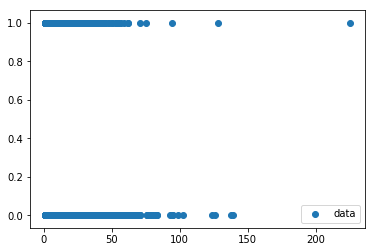

In [101]:
plt.scatter(fraud_name['changed_name'], fraud_name['is_black'], label="data", marker='o')

plt.legend(loc = "best")
plt.show()

In [27]:
np.exp(logis.params)

Intercept       0.001146
changed_name    1.180193
dtype: float64

In [28]:
params = logis.params
conf = logis.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

                  2.5%     97.5%        OR
Intercept     0.001114  0.001178  0.001146
changed_name  1.173972  1.186447  1.180193


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [72]:
Y = fraud_name['is_black']
X = fraud_name.drop(['is_black'], axis=1)

# Y.reshape(1, -1)
# X = X.reshape(1, -1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)


In [118]:
log_clf = LogisticRegression()
log_clf.fit(X_train,Y_train)  # training 데이터로 학습 시키기
log_clf.score(X_test, Y_test)  # the mean accuracy on the given test data and labels.

/Users/quicket/python-bunjang/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9984711882481755

In [142]:
#test(valid)/train 을 2:8 로 randomly select
train, valid = train_test_split(fraud_name, test_size=0.2, random_state=0)

#train/valid set 완성
train_y = train['is_black']
train_x = train.drop(['is_black'], axis=1)

valid_y = valid['is_black']
valid_x = valid.drop(['is_black'],axis=1)

In [137]:
# lr = LogisticRegression(C=1000.0, random_state=0)

lr = LogisticRegression()
lr.fit(train_x, train_y)  # Fit the model according to the given training data.
pred_y = lr.predict(valid_x)  # Predict class labels for samples in X.

/Users/quicket/python-bunjang/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [138]:
pred_y

array([0, 0, 0, ..., 0, 0, 0])

In [141]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 1915


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

print("accuracy: %.3f" %accuracy_score(valid_y, pred_y))  # Accuracy classification score
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.998


/Users/quicket/python-bunjang/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision : 0.000
Recall : 0.000
F1 : 0.000


/Users/quicket/python-bunjang/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [106]:
fraud_name_10 = fraud_name[fraud_name['changed_name'] <= 10]

In [109]:
y = fraud_name_10['is_black']
X = fraud_name_10['changed_name']

logit_mod = sm.Logit(y, X)
# logit_res = logit_mod.fit(disp=0)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.023258
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               is_black   No. Observations:              4084758
Model:                          Logit   Df Residuals:                  4084757
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Jul 2019   Pseudo R-squ.:                  -1.114
Time:                        16:14:22   Log-Likelihood:                -95004.
converged:                       True   LL-Null:                       -44933.
                                        LLR p-value:                       nan
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
changed_name    -5.3635      0.008   -654.274      0.000      -5.380      -5.347

Possibly complete qua

In [110]:
logit_res = sm.Logit.from_formula('is_black ~ changed_name', fraud_name_10).fit()

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.010553
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_black   No. Observations:              4084758
Model:                          Logit   Df Residuals:                  4084756
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Jul 2019   Pseudo R-squ.:                 0.04062
Time:                        16:15:20   Log-Likelihood:                -43108.
converged:                       True   LL-Null:                       -44933.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.2815      0.019   -389.763      0.000      -7.318      -7.245
changed_name     0.4246      0.005     78.381      0.000       0.414       0.435
================================================================================
"""